In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srishtidixit0811","key":"1a3e778ca6d47e5f829497a31cb2aea1"}'}

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d thienkhonghoc/affectnet

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown
100% 1.74G/1.75G [00:15<00:00, 222MB/s]
100% 1.75G/1.75G [00:15<00:00, 118MB/s]


In [5]:
!unzip -q /content/affectnet.zip -d /content/affectnet > /dev/null 2>&1

In [6]:
!pip install mediapipe opencv-python numpy pandas tensorflow keras albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 52.9 MB/s eta 0:00:00


In [7]:
!pip install --upgrade mediapipe opencv-python tqdm


In [ ]:
import os
os._exit(00)

In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tqdm import tqdm  # Progress bar

# Enable GPU processing
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled and available.")
    except RuntimeError as e:
        print("GPU setup error:", e)
else:
    print("No GPU found, running on CPU.")

# Set Correct Paths
DATASET_PATH = "/content/affectnet/AffectNet/"  # Main dataset directory
PROCESSED_PATH = "/content/AffectNet_Preprocessed/"  # Where processed images will be saved
BATCH_SIZE = 5000  # Reduce batch size if Colab runs out of memory

# Create directory for processed images
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Initialize Mediapipe Face Detector
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)

# Function to detect and process faces in batches using GPU
@tf.function  # JIT compilation for GPU acceleration
def process_batch(batch_files, label, subset, save_path):
    for img_file in tqdm(batch_files, desc=f"Processing {subset}/{label}"):
        img_path = os.path.join(DATASET_PATH, subset, label, img_file)
        save_subset_path = os.path.join(save_path, subset, label)
        os.makedirs(save_subset_path, exist_ok=True)  # Ensure subset directories exist

        save_file_path = os.path.join(save_subset_path, img_file)

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is not valid

        # Convert to RGB and process with Mediapipe
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_detection.process(img_rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = img.shape
                x, y, w, h = int(bboxC.xmin * w), int(bboxC.ymin * h), int(bboxC.width * w), int(bboxC.height * h)

                # Ensure face bounding box is valid
                if x < 0 or y < 0 or w <= 10 or h <= 10:
                    continue  # Skip images with invalid face detection

                face = img[y:y + h, x:x + w]

                # Ensure the cropped face is not empty
                if face is None or face.shape[0] == 0 or face.shape[1] == 0:
                    continue  # Skip empty images

                # Use OpenCV CUDA for GPU-accelerated resizing
                if cv2.cuda.getCudaEnabledDeviceCount() > 0:
                    gpu_img = cv2.cuda_GpuMat()
                    gpu_img.upload(face)
                    gpu_img = cv2.cuda.resize(gpu_img, (224, 224))
                    face = gpu_img.download()
                else:
                    face = cv2.resize(face, (224, 224))

                # Convert to grayscale
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

                # Save processed image
                cv2.imwrite(save_file_path, face)

# Process images in batches for train, val, and test sets
for subset in ["train", "val", "test"]:
    subset_path = os.path.join(DATASET_PATH, subset)

    if not os.path.exists(subset_path):
        print(f"Warning: {subset_path} does not exist. Skipping...")
        continue  # Skip if directory does not exist

    for label in os.listdir(subset_path):
        label_path = os.path.join(subset_path, label)
        save_label_path = os.path.join(PROCESSED_PATH, subset, label)

        if not os.path.isdir(label_path):
            continue  # Skip files, only process directories

        image_files = os.listdir(label_path)

        # Process in chunks of BATCH_SIZE
        for i in range(0, len(image_files), BATCH_SIZE):
            batch_files = image_files[i:i + BATCH_SIZE]
            process_batch(batch_files, label, subset, PROCESSED_PATH)
            print(f"Processed {len(batch_files)} images in batch for {subset}/{label}")


GPU is enabled and available.


Processing train/3:   0%|          | 0/5000 [00:00<?, ?it/s]WARNING:tensorflow:AutoGraph could not transform <function makedirs at 0x7a8dec107d80> and will run it as-is.
Cause: Unable to locate the source code of <function makedirs at 0x7a8dec107d80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function makedirs at 0x7a8dec107d80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Processing train/3: 100%|██████████| 5000/5000 [01:00<00:00, 82.37it/s]


Processed 5000 images in batch for train/3


Processing train/6: 100%|██████████| 5000/5000 [00:55<00:00, 89.49it/s]


Processed 5000 images in batch for train/6


Processing train/0: 100%|██████████| 5000/5000 [00:53<00:00, 93.06it/s] 


Processed 5000 images in batch for train/0


Processing train/4: 100%|██████████| 5000/5000 [00:54<00:00, 91.22it/s]


Processed 5000 images in batch for train/4


Processing train/1: 100%|██████████| 3803/3803 [00:40<00:00, 93.02it/s] 


Processed 3803 images in batch for train/1


Processing train/5: 100%|██████████| 5000/5000 [00:58<00:00, 84.98it/s]


Processed 5000 images in batch for train/5


Processing train/7: 100%|██████████| 3750/3750 [00:42<00:00, 87.76it/s]


Processed 3750 images in batch for train/7


Processing train/2: 100%|██████████| 5000/5000 [00:53<00:00, 93.63it/s]


Processed 5000 images in batch for train/2


Processing val/3: 100%|██████████| 100/100 [00:01<00:00, 80.65it/s]


Processed 100 images in batch for val/3


Processing val/6: 100%|██████████| 100/100 [00:01<00:00, 83.91it/s]


Processed 100 images in batch for val/6


Processing val/0: 100%|██████████| 100/100 [00:01<00:00, 93.39it/s]


Processed 100 images in batch for val/0


Processing val/4: 100%|██████████| 100/100 [00:01<00:00, 95.28it/s]


Processed 100 images in batch for val/4


Processing val/1: 100%|██████████| 100/100 [00:01<00:00, 91.59it/s]


Processed 100 images in batch for val/1


Processing val/5: 100%|██████████| 100/100 [00:01<00:00, 92.65it/s]


Processed 100 images in batch for val/5


Processing val/7: 100%|██████████| 100/100 [00:01<00:00, 62.56it/s]


Processed 100 images in batch for val/7


Processing val/2: 100%|██████████| 100/100 [00:01<00:00, 70.95it/s]


Processed 100 images in batch for val/2


Processing test/3: 100%|██████████| 400/400 [00:04<00:00, 83.64it/s]


Processed 400 images in batch for test/3


Processing test/6: 100%|██████████| 400/400 [00:04<00:00, 91.52it/s]


Processed 400 images in batch for test/6


Processing test/0: 100%|██████████| 400/400 [00:04<00:00, 81.05it/s]


Processed 400 images in batch for test/0


Processing test/4: 100%|██████████| 400/400 [00:04<00:00, 94.20it/s]


Processed 400 images in batch for test/4


Processing test/1: 100%|██████████| 400/400 [00:04<00:00, 80.76it/s]


Processed 400 images in batch for test/1


Processing test/5: 100%|██████████| 400/400 [00:04<00:00, 90.55it/s]


Processed 400 images in batch for test/5


Processing test/7: 100%|██████████| 400/400 [00:04<00:00, 87.88it/s]


Processed 400 images in batch for test/7


Processing test/2: 100%|██████████| 400/400 [00:05<00:00, 78.25it/s]

Processed 400 images in batch for test/2


In [2]:
!pip install tensorflow keras


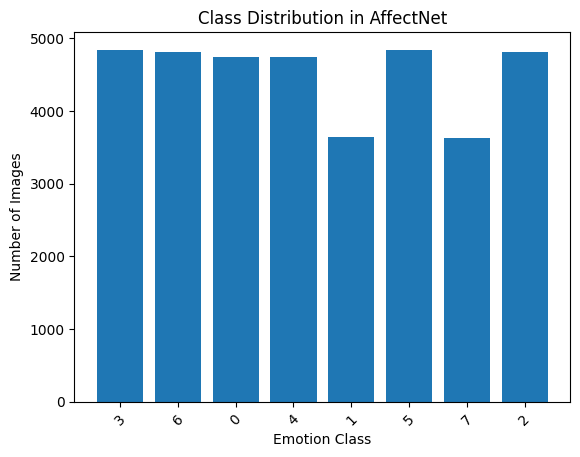

Class Distribution: {'3': 4837, '6': 4803, '0': 4738, '4': 4741, '1': 3635, '5': 4843, '7': 3625, '2': 4806}


In [3]:
import os
import matplotlib.pyplot as plt

PROCESSED_PATH = "/content/AffectNet_Preprocessed/train/"

class_counts = {label: len(os.listdir(os.path.join(PROCESSED_PATH, label))) for label in os.listdir(PROCESSED_PATH)}

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in AffectNet")
plt.xticks(rotation=45)
plt.show()

print("Class Distribution:", class_counts)


In [4]:
!nvidia-smi

Tue Mar  4 22:44:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             32W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#v4.3
#Save Model After Every Few Epochs
#Using stronger data augmentation (distortions, random brightness, contrast).
#Reduced Memory Usage
#Training with a lower learning rate (1e-6 after ReduceLROnPlateau triggers again).
#Saves and resumes training from the last checkpoint.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Check GPU
print("Checking GPU status...")
!nvidia-smi

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU enabled.")
else:
    print("No GPU detected.")

tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Paths
PROCESSED_PATH = "/content/AffectNet_Preprocessed/"
checkpoint_path = "best_augmented_model.keras"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    PROCESSED_PATH + "train",
    target_size=(224, 224),
    batch_size=16,  # Reduced batch size
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    PROCESSED_PATH + "train",
    target_size=(224, 224),
    batch_size=16,  # Reduced batch size
    class_mode="categorical"
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

# Load previous model if exists
if os.path.exists(checkpoint_path):
    print("Loading previous checkpoint...")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found. Training from scratch.")

    # Load EfficientNet-B4
    base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last 50 layers
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Build model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(len(class_labels), activation="softmax", dtype="float32")
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Model compiled successfully.")

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_accuracy")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train model in 5-epoch intervals
epochs_completed = 0
max_epochs = 30

while epochs_completed < max_epochs:
    print(f"Starting training from epoch {epochs_completed + 1} to {epochs_completed + 5}")

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs_completed + 5,  # Train in smaller steps
        initial_epoch=epochs_completed,
        callbacks=[early_stop, checkpoint, reduce_lr]
    )

    # Save model after every 5 epochs
    model.save(checkpoint_path)

    epochs_completed += 5

print("Model training completed.")


Checking GPU status...
Tue Mar  4 22:46:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             33W /   70W |     230MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 953s 336ms/step - accuracy: 0.1447 - loss: 2.0931 - val_accuracy: 0.2683 - val_loss: 1.9047 - learning_rate: 1.0000e-05
Epoch 2/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 611s 271ms/step - accuracy: 0.2463 - loss: 1.9367 - val_accuracy: 0.3251 - val_loss: 1.7658 - learning_rate: 1.0000e-05
Epoch 3/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 610s 271ms/step - accuracy: 0.2986 - loss: 1.8083 - val_accuracy: 0.3960 - val_loss: 1.5951 - learning_rate: 1.0000e-05
Epoch 4/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 608s 270ms/step - accuracy: 0.3356 - loss: 1.7193 - val_accuracy: 0.4185 - val_loss: 1.5351 - learning_rate: 1.0000e-05
Epoch 5/5
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 624s 277ms/step - accuracy: 0.3692 - loss: 1.6416 - val_accuracy: 0.4156 - val_loss: 1.5400 - learning_rate: 1.0000e-05
Starting training from epoch 6 to 10
Epoch 6/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 639s 284ms/step - accuracy: 0.3736 - loss: 1.6493 - val_accuracy: 0.4691 - val_loss: 1.4194 - learning_rate: 1.0000e

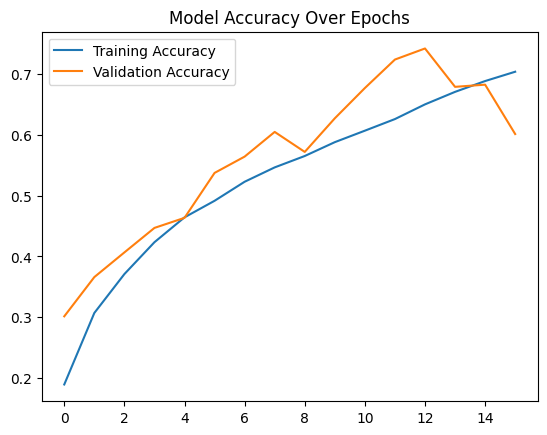

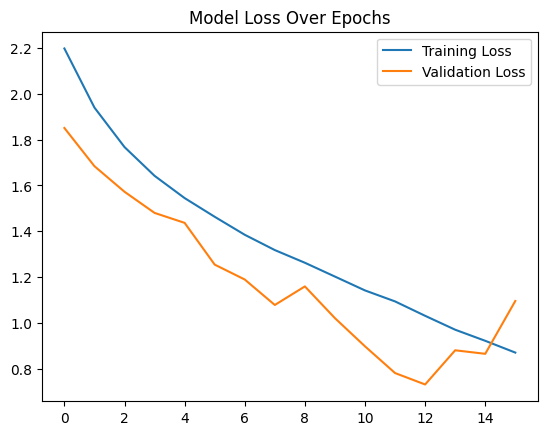

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()


In [ ]:
# Save model using TensorFlow's recommended format
model.save("best_model.keras")


In [ ]:
from tensorflow.keras.models import load_model

# Load the model in Keras format
model = load_model("best_model.keras")

print("Model loaded successfully!")


Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 422 variables whereas the saved optimizer has 846 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving download.jpeg to download.jpeg


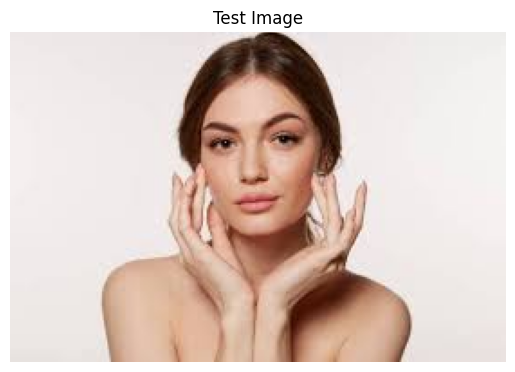

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the uploaded image
test_image_path = "download.jpeg"  # Change this to your image file name
input_image = preprocess_image(test_image_path)

# Display the image
plt.imshow(cv2.imread(test_image_path)[:, :, ::-1])
plt.axis("off")
plt.title("Test Image")
plt.show()


In [ ]:
# Make a prediction
predictions = model.predict(input_image)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class labels (emotion categories)
class_labels = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # Update based on AffectNet dataset

# Print the predicted emotion
print(f"Predicted Emotion: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Predicted Emotion: Happiness


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving download_Sad.jpeg to download_Sad.jpeg


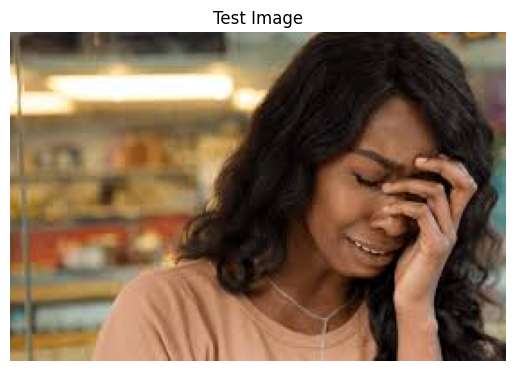

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the uploaded image
test_image_path = "download_Sad.jpeg"  # Change this to your image file name
input_image = preprocess_image(test_image_path)

# Display the image
plt.imshow(cv2.imread(test_image_path)[:, :, ::-1])
plt.axis("off")
plt.title("Test Image")
plt.show()


In [ ]:
# Make a prediction
predictions = model.predict(input_image)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class labels (emotion categories)
class_labels = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # Update based on AffectNet dataset

# Print the predicted emotion
print(f"Predicted Emotion: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Emotion: Sadness


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving download2.jpeg to download2.jpeg


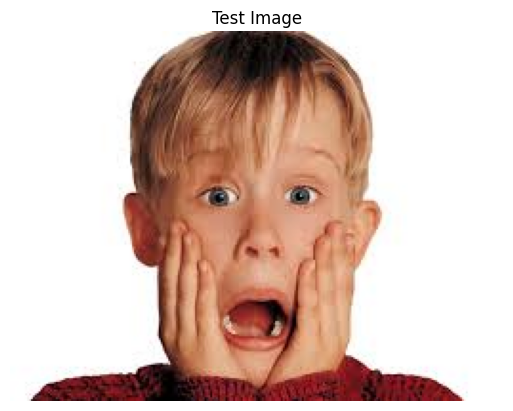

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the uploaded image
test_image_path = "download2.jpeg"  # Change this to your image file name
input_image = preprocess_image(test_image_path)

# Display the image
plt.imshow(cv2.imread(test_image_path)[:, :, ::-1])
plt.axis("off")
plt.title("Test Image")
plt.show()


In [ ]:
# Make a prediction
predictions = model.predict(input_image)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class labels (emotion categories)
class_labels = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # Update based on AffectNet dataset

# Print the predicted emotion
print(f"Predicted Emotion: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Emotion: Disgust


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving download (1).jpeg to download (1).jpeg


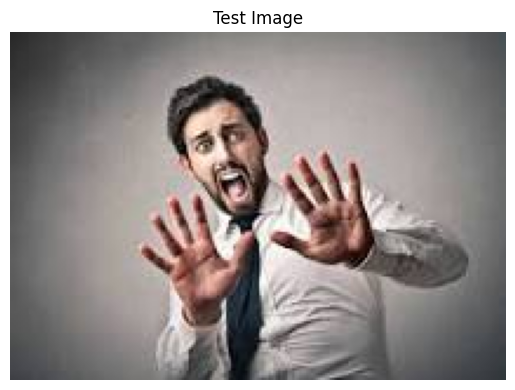

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the uploaded image
test_image_path = "download (1).jpeg"  # Change this to your image file name
input_image = preprocess_image(test_image_path)

# Display the image
plt.imshow(cv2.imread(test_image_path)[:, :, ::-1])
plt.axis("off")
plt.title("Test Image")
plt.show()


In [ ]:
# Make a prediction
predictions = model.predict(input_image)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class labels (emotion categories)
class_labels = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # Update based on AffectNet dataset

# Print the predicted emotion
print(f"Predicted Emotion: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Emotion: Neutral
